# Crowd detection from drones

The method is based on a multi-output fully-convolutional neural network already trained on a subset of the challenging [VisDrone](https://github.com/VisDrone) dataset (specifically Task 1 and Task 2). Evaluted on a hold-out test set, the model achieved about 86% of prediction accuracy in separating crowded (more than 10 people) from non-crowded (less than 10 people) scenes. It is worth remarking that by lowering the confidence threshold of the deep network, very high recall can be obtained (about 97%) without affecting too much precision (about 78%). 

In [1]:
# load libraries
%tensorflow_version 1.x

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
!wget https://github.com/MarcoCia/Crowd-Estimation/archive/master.zip
import zipfile as z
with z.ZipFile('/content/master.zip', 'r') as zip_ref:
  zip_ref.extractall()

TensorFlow 1.x selected.
--2020-05-12 13:23:14--  https://github.com/MarcoCia/Crowd-Estimation/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/MarcoCia/Crowd-Estimation/zip/master [following]
--2020-05-12 13:23:14--  https://codeload.github.com/MarcoCia/Crowd-Estimation/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [   <=>              ]  27.31M  12.6MB/s    in 2.2s    

2020-05-12 13:23:17 (12.6 MB/s) - ‘master.zip’ saved [28641220]



# Scegliere il modello che si vuole caricare 

In [0]:

#path='/content/Crowd-Estimation-master/regression_FineTuning2visdrone2020_count_128.38-9.60.hdf5'  #MODELLO SU VISDRONE2020
path='/content/Crowd-Estimation-master/regression_FineTuning_count_128.01-8.12.hdf5'   #MODELLO SU VISDRONE2019
model = tf.keras.models.load_model(path)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
train_ds (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
p_re_lu (PReLU)              (None, 128, 128, 32)      524288    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
___________________________________________

The method requires the input image to be preprocessed before being fed to the neural network.

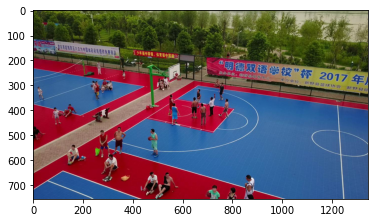

In [0]:
# load image
img_path = "/content/Crowd-Estimation-master/ImgaesDefinitive/uav0000086_00000_v_0000055.jpg"
img = mpimg.imread(img_path)
plt.imshow(img)

In [0]:
# preprocess image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

We use the class activation map method described in https://arxiv.org/abs/1610.02391 to output a heatmap highlighting the image regions that have been activated by the class prediction the most.


# GRAD_CAM

In [0]:
pred = model.predict(x)
print(pred)

[[49.37873]]


In [0]:
# extract heatmap

output = model.output[0]
last_conv_layer = model.get_layer('conv2d_1')

grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

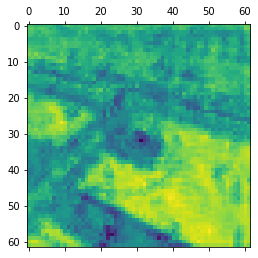

In [0]:
# show heatmap
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
#heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [0]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1)]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [0]:
import matplotlib
discretized_jet = cmap_discretize(matplotlib.cm.jet_r, 9)

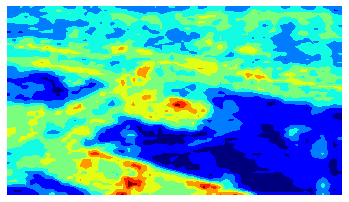

In [0]:
# save heatmap
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255* heatmap2)
#cmap=cv2.COLORMAP_JET
#heatmap_cmap = cv2.applyColorMap(heatmap2*255, cmap)
plt.axis('off')
plt.imshow(heatmap2, cmap=discretized_jet)
#cv2.imwrite("/content/heatmap.jpg", heatmap_cmap)